In [17]:
%pip install selenium beautifulsoup4 nltk matplotlib wordcloud

Note: you may need to restart the kernel to use updated packages.


In [18]:
%pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Verify NLTK resources
import nltk
nltk.data.path.append('./nltk_data')

from nltk.corpus import stopwords
print("First 10 stopwords:", stopwords.words('english')[:10])

# Verify Selenium
from selenium import webdriver
print("Selenium is working!")

# Verify Matplotlib and WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
print("Matplotlib and WordCloud are working!")

import seaborn as sns

First 10 stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
Selenium is working!
Matplotlib and WordCloud are working!


In [20]:
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

# Ensure NLTK data path
nltk.data.path.append('./nltk_data')

# Download necessary NLTK data if not already available
nltk.download('stopwords', download_dir='./nltk_data')
nltk.download('punkt', download_dir='./nltk_data')

STOPWORDS = set(stopwords.words('english'))
PUNCTUATION = set(['.', ',', '!', '?', ':', ';', '-', '’', '“', '”', '…'])


[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import json
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

# Define categories and associated URLs
CATEGORIES = {
    "World": [
        "https://x.com/CNN", "https://x.com/Reuters", "https://x.com/AP", "https://x.com/BBCWorld",
        "https://x.com/NBCNews", "https://x.com/NYTimesWorld", "https://x.com/AFP", 
        "https://x.com/guardian", "https://x.com/abcnews", "https://x.com/CTVNews", "https://x.com/NewsHour",
        "https://x.com/globaltimesnews", "https://x.com/RT_com", "https://x.com/europarl_EN", 
        "https://x.com/BreakingNews", "https://x.com/ReutersLive", "https://x.com/SkyNews",
        "https://x.com/thedailybeast", "https://x.com/time"
    ],
    "Business": [
        "https://x.com/WSJ", "https://x.com/federalreserve", "https://x.com/Business", 
        "https://x.com/FinancialTimes", "https://x.com/CNBC", "https://x.com/Bloomberg", 
        "https://x.com/businessinsider", "https://x.com/MarketWatch", "https://x.com/economics",
        "https://x.com/forbes", "https://x.com/TheEconomist", "https://x.com/YahooFinance",
        "https://x.com/smallbiztrends", "https://x.com/NASDAQ", "https://x.com/SPGlobal",
        "https://x.com/SchwabResearch", "https://x.com/WSJMarkets", "https://x.com/morningstarinc",
        "https://x.com/IBDinvestors", "https://x.com/BizTimesMedia"
    ],
    "Music": [
        "https://x.com/billboard", "https://x.com/rollingstone", "https://x.com/NME", "https://x.com/pitchfork",
        "https://x.com/MusicWeek", "https://x.com/ComplexMusic", "https://x.com/MTV",
        "https://x.com/BBCR1", "https://x.com/BET", "https://x.com/AppleMusic", "https://x.com/Spotify",
        "https://x.com/rapradar", "https://x.com/soundcloud", "https://x.com/Beats1",
        "https://x.com/popjustice", "https://x.com/AltPress", "https://x.com/classicfm",
        "https://x.com/HotNewHipHop", "https://x.com/SONGKICK", "https://x.com/officialcharts"
    ],
    "Sports": [
        "https://x.com/ESPN", "https://x.com/FIFAWorldCup", "https://x.com/NBA", "https://x.com/MLB",
        "https://x.com/NFL", "https://x.com/Olympics", "https://x.com/UFC", "https://x.com/NHL",
        "https://x.com/espnfc", "https://x.com/skyfootball", "https://x.com/F1", "https://x.com/NBAGLeague",
        "https://x.com/ICC", "https://x.com/rugbyworldcup", "https://x.com/LPGA", "https://x.com/NASCAR",
        "https://x.com/NCAAFootball", "https://x.com/cricketworldcup", "https://x.com/espnW",
        "https://x.com/MotoGP"
    ],
    "Technology": [
        "https://x.com/verge", "https://x.com/wired", "https://x.com/TechCrunch", "https://x.com/gizmodo",
        "https://x.com/engadget", "https://x.com/CNET", "https://x.com/zdnet", "https://x.com/arstechnica",
        "https://x.com/mashable", "https://x.com/digitaltrends", "https://x.com/recode",
        "https://x.com/VentureBeat", "https://x.com/thenextweb", "https://x.com/slashdot",
        "https://x.com/macrumors", "https://x.com/gsmarena", "https://x.com/androidcentral",
        "https://x.com/hardwarezone", "https://x.com/9to5mac", "https://x.com/PCMag"
    ]
}


def init_driver(headless=True):
    options = Options()
    if headless:
        options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    return webdriver.Chrome(options=options)

def scroll_and_scrape(driver, max_scrolls=10):
    tweets = []
    seen_texts = set()

    for _ in range(max_scrolls):
        driver.execute_script("window.scrollBy(0, 300);")
        time.sleep(1)

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        for tweet in soup.find_all('article'):
            text = tweet.find(['div', 'span'], {'data-testid': 'tweetText'})
            if text and text.get_text() not in seen_texts:
                tweets.append(text.get_text())
                seen_texts.add(text.get_text())

    return tweets

def scrape_account(url, headless=True, max_retries=5):
    driver = init_driver(headless)
    driver.get(url)

    tweets = []
    retries = 0

    while retries < max_retries and not tweets:
        try:
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, "//div[@data-testid='tweetText']"))
            )
            tweets = scroll_and_scrape(driver)
        except Exception as e:
            print(f"Retry {retries + 1}/{max_retries} - Waiting for tweets...")
            retries += 1
            time.sleep(2)

    driver.quit()
    if tweets:
        print(f"Collected {len(tweets)} tweets from {url}.")
    else:
        print(f"Failed to collect tweets from {url} after {max_retries} retries.")
    
    return tweets

def select_category():
    print("Available categories:")
    for i, category in enumerate(CATEGORIES, 1):
        print(f"{i}. {category}")

    choice = int(input("Select a category by number: ")) - 1
    category_name = list(CATEGORIES.keys())[choice]
    return category_name, CATEGORIES[category_name]

def scrape_multiple_accounts(urls, headless=True, max_retries=5):
    unique_urls = list(set(urls))  # Remove duplicate URLs if any
    all_tweets_set = set()  # Store unique tweets only

    with ThreadPoolExecutor(max_workers=len(unique_urls)) as executor:
        future_to_url = {executor.submit(scrape_account, url, headless, max_retries): url for url in unique_urls}

        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                tweets = future.result()
                all_tweets_set.update(tweets)  # Add tweets to set for uniqueness
            except Exception as exc:
                print(f"Exception occurred while scraping {url}: {exc}")

    return list(all_tweets_set)  # Convert set to list for final output

In [22]:
if __name__ == "__main__":
    category, urls = select_category()
    print(f"Scraping tweets for category: {category}")

    # Scrape multiple accounts concurrently
    all_tweets = scrape_multiple_accounts(urls, headless=True)
    print(f"\nTotal unique tweets collected: {len(all_tweets)}\n")

    # Save unique tweets to a JSON file
    with open("tweets.json", "w", encoding="utf-8") as file:
        json.dump(all_tweets, file, ensure_ascii=False, indent=2)
    print("All unique tweets have been saved to tweets.json")

Available categories:
1. World
2. Business
3. Music
4. Sports
5. Technology
Scraping tweets for category: World
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...Retry 1/5 - Waiting for tweets...

Retry 1/5 - Waiting for tweets...
Retry 2/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 2/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 2/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 1/5 - Waiting for tweets...
Retry 2/5 - Waiting for tweets...
Retry 3/5 - Waiting for tweets...
Retry 4/5 - Waiting for tweets...
Retry 5/5 - Waiting for tweets...
Failed to collect tweets from https://x.com/ReutersLive after 5 retries.
Collected 12 tweets from https://x.com/CNN.
Collected 11 tweets fro

In [23]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    words = text.lower().split()
    return [word for word in words if word not in STOPWORDS and word not in PUNCTUATION]

def extract_keywords(texts, top_n=20):
    all_words = []
    for text in texts:
        all_words.extend(preprocess_text(text))
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

# Extract top 10 keywords from scraped tweets
keywords = extract_keywords(all_tweets, top_n=10)
print("Top Keywords:", keywords)


Top Keywords: [('new', 31), ('us', 29), ('trump', 28), ('says', 14), ('donald', 13), ('president', 13), ('two', 12), ('man', 12), ('breaking', 11), ('say', 11)]


Generating Word Cloud...


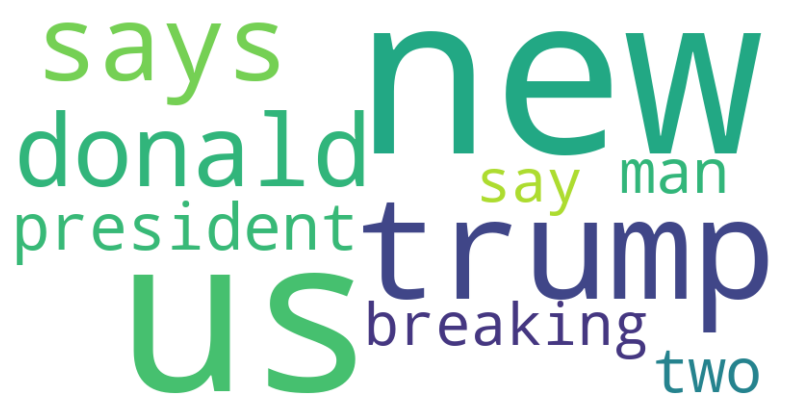

Generating Bar Plot...


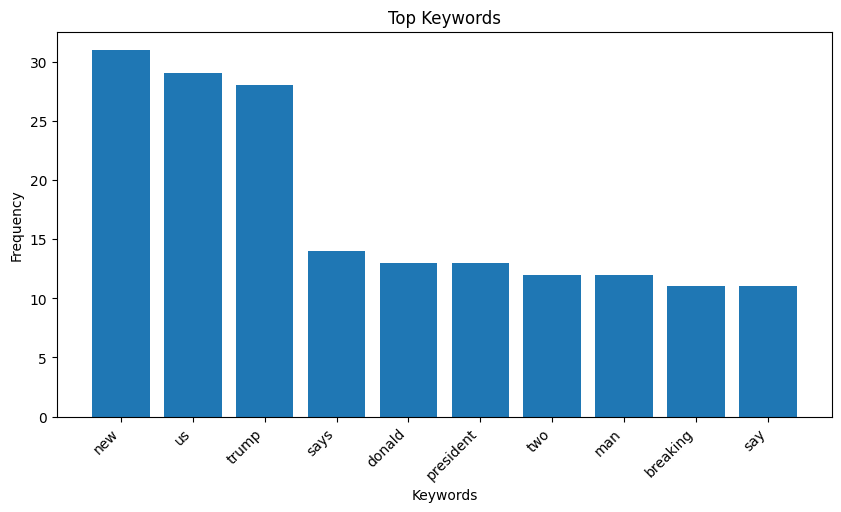

Generating Bar Plot...


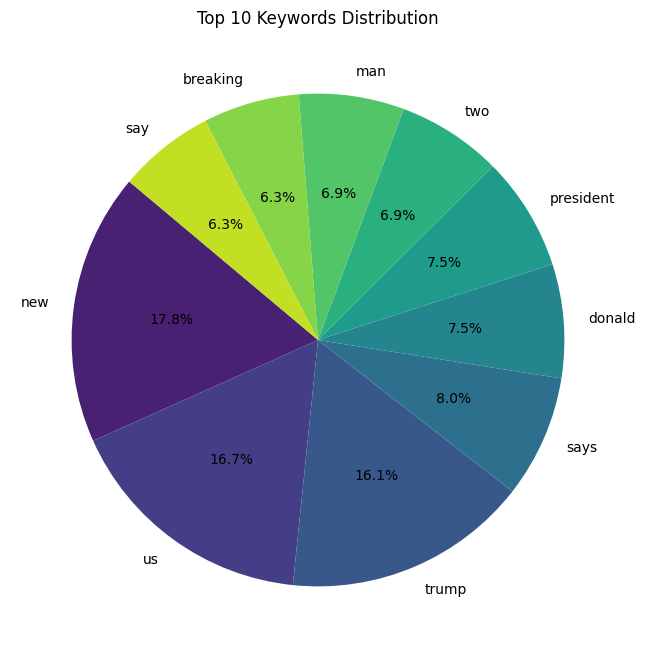

In [24]:
def generate_wordcloud(keywords):
    word_freq = {word: freq for word, freq in keywords}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def generate_bar_plot(keywords):
    words, frequencies = zip(*keywords)

    plt.figure(figsize=(10, 5))
    plt.bar(words, frequencies)
    plt.xlabel('Keywords')
    plt.ylabel('Frequency')
    plt.title('Top Keywords')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Generate and display a pie chart
def generate_pie_chart(keywords, top_n=10):
    """Generate and display a pie chart for top N keywords."""
    keywords = sorted(keywords, key=lambda x: x[1], reverse=True)[:top_n]
    words, frequencies = zip(*keywords)

    plt.figure(figsize=(8, 8))
    plt.pie(frequencies, labels=words, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(words)))
    plt.title(f'Top {top_n} Keywords Distribution')
    plt.show()

# Generate visualizations
print("Generating Word Cloud...")
generate_wordcloud(keywords)

print("Generating Bar Plot...")
generate_bar_plot(keywords)

print("Generating Bar Plot...")
generate_pie_chart(keywords)
